In [2]:
import pandas as pd, sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, calendar, time
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.ticker
%matplotlib inline

### Set the city for analysis
Loads the city file from `../data`

In [3]:
PLACE = "detroit_michigan"

Read in the versions file

In [4]:
header = ['id','type','amenity','highway','building','name','length','area','aA','aD','aM','user', 'version','minorVersion','validSince','validUntil','changeset','center']

In [5]:
df = pd.read_csv('../data/'+PLACE+'-all-stats.data',names=header, sep='\t',index_col=None)
df.sort_values(by='validSince',inplace=True)
df = df.reset_index(drop=True)
df.head(2)

,id,type,amenity,highway,building,name,length,area,aA,aD,aM,user,version,minorVersion,validSince,validUntil,changeset,center
0,11753030,node,NaN,traffic_signals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,purpleduck,1,NaN,1154027235,1204584703,68453,"-83.0171595,42.2546319"
1,18353607,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rw_,1,NaN,1161039615,1206935185,133880,"-82.5525158,42.2359087"


Calculate new columns and convert to Python objects

In [6]:
df['date'] = df.validSince.apply(lambda x: pd.Timestamp(x*1000000000).date())
df.replace("false", np.NaN, inplace=True)
df.validUntil = df['validUntil'].astype(float)

In [6]:
df.id.count(), df.id.nunique(), df.user.nunique(), df.query('version==1').id.nunique()

(317662, 151522, 1042, 151519)

In [7]:
#Cast length and area to floats
df.length = pd.to_numeric(df.length, downcast='float')
df.area = pd.to_numeric(df.length, downcast='float')
df.version = pd.to_numeric(df.version, downcast='integer')

# 1. Kilometers of roads overtime

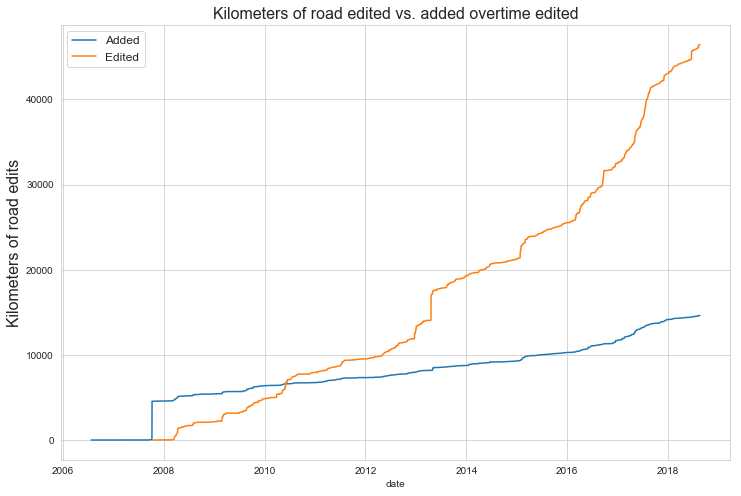

In [8]:
sns.set_style('whitegrid')
hw = df[~pd.isnull(df.highway)]
ax = hw[hw.version==1].groupby('date').aggregate({'length':sum}).cumsum().plot(figsize=(12,8),legend=None)
hw[hw.version>1].groupby('date').aggregate({'length':sum}).cumsum().plot(ax=ax,legend=None)
ax.set_ylabel("Kilometers of road edits",fontsize=16)
ax.set_title("Kilometers of road edited vs. added overtime edited",fontsize=16);
ax.legend(['Added','Edited'], loc=0, fontsize=12);

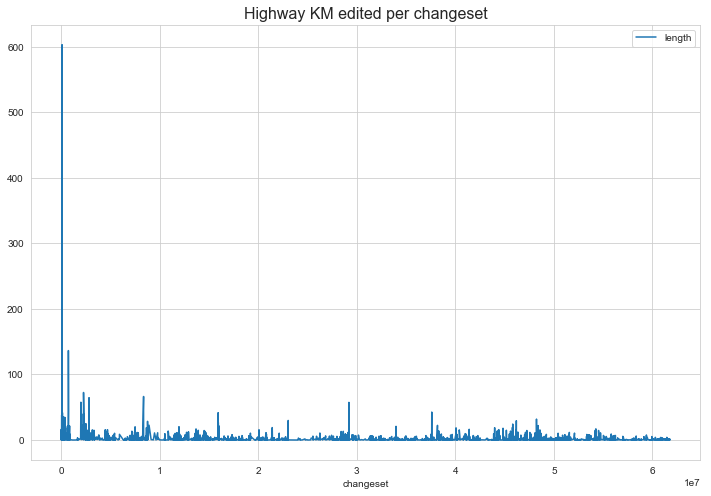

In [9]:
ax = hw[hw.version==1].groupby('changeset').aggregate({'length':sum}).plot(figsize=(12,8))
ax.set_title('Highway KM edited per changeset',fontsize=16);

# 2 Buildings Overtime

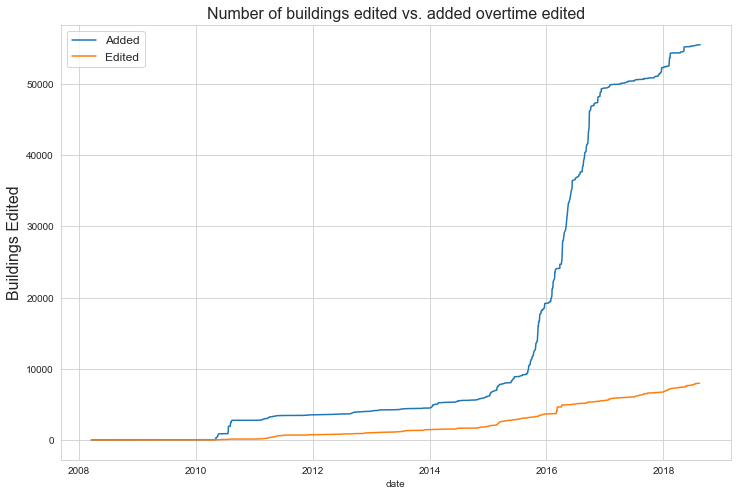

In [10]:
sns.set_style('whitegrid')
buildings = df[~pd.isnull(df.building)]
ax = buildings[(buildings.version==1) & (buildings.minorVersion==0)].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(figsize=(12,8),legend=None)
buildings[buildings.version>1].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(ax=ax,legend=None)
ax.set_ylabel("Buildings Edited",fontsize=16)
ax.set_title("Number of buildings edited vs. added overtime edited",fontsize=16);
ax.legend(['Added','Edited'], loc=0, fontsize=12);

### Top Building Contributors (Added)

In [11]:
buildings[(buildings.minorVersion==0) & (buildings.version==1)].groupby('user').aggregate({'id':'count'}).sort_values(by='id',ascending=False).head(10)


,id
user,
markscalf,20448
Aibara,15907
PeterEastern,2720
Tyson Gersh,1863
leppekmi,1785
MintCondition,1752
dexterslu,1327
DougPeterson,1036
Stevedawg313,864


### Top Building Contributors (Recently)

In [12]:
buildings[(buildings.minorVersion==0) & (buildings.version==1) & (buildings.date > datetime.date(2018,8,1))].groupby('user').aggregate({'id':'count'}).sort_values(by='id',ascending=False).head(10)


,id
user,
Osgood,23
Jonah Adkins,13
lmum,3
Flight Detroit,2
StackKorora,1
StudentinGear,1


# 3 Amenities Overtime

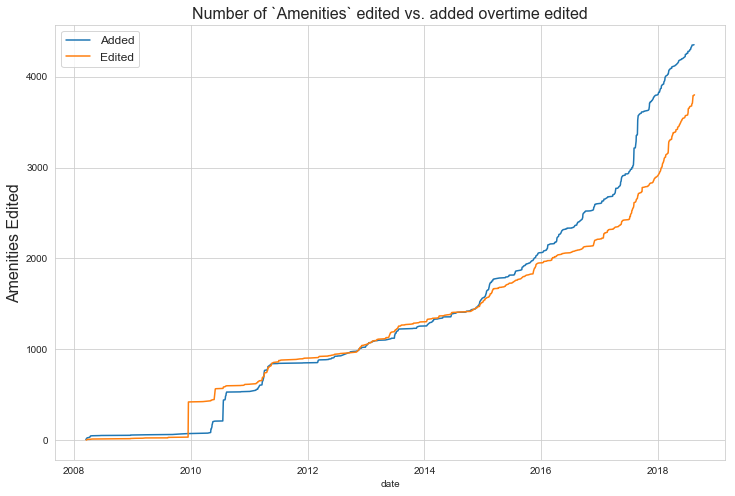

In [13]:
sns.set_style('whitegrid')
amenities = df[~pd.isnull(df.amenity)]
ax = amenities[(amenities.version==1) & (amenities.minorVersion==0)].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(figsize=(12,8),legend=None)
amenities[amenities.version>1].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(ax=ax,legend=None)
ax.set_ylabel("Amenities Edited",fontsize=16)
ax.set_title("Number of `Amenities` edited vs. added overtime edited",fontsize=16);
ax.legend(['Added','Edited'], loc=0, fontsize=12);

# 4 Contributors per week ... an editing pulse?

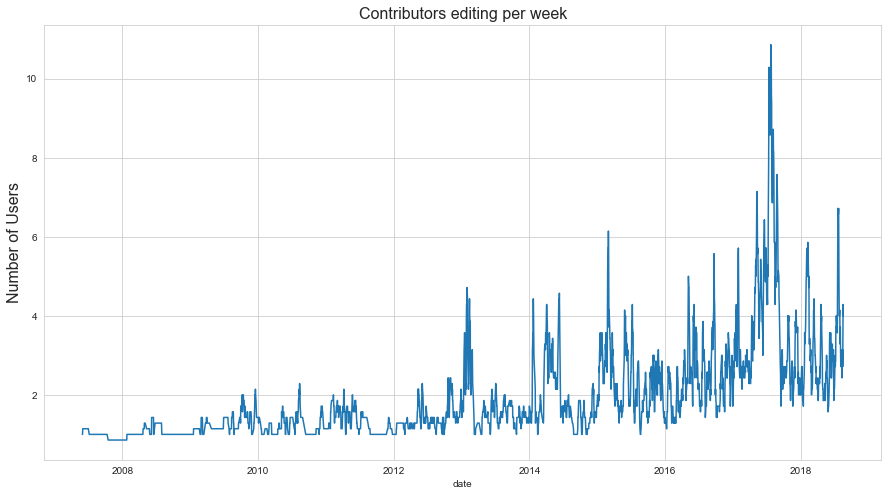

In [14]:
ax = df.groupby('date').aggregate({'user':'nunique'}).rolling(7).mean().plot(figsize=(15,8),legend=None)
ax.set_ylabel("Number of Users",fontsize=16)
ax.set_title("Contributors editing per week",fontsize=16);

# 5 Edits per week?

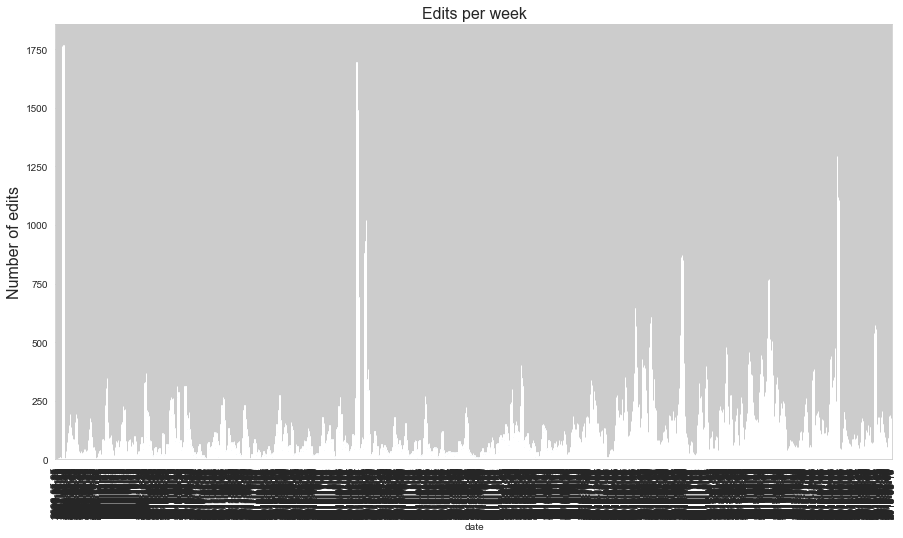

In [15]:
ax = df.groupby('date').aggregate({'id':'count'}).rolling(7).mean().plot(kind='bar',figsize=(15,8),legend=None)
ax.set_ylabel("Number of edits",fontsize=16)
ax.set_title("Edits per week",fontsize=16);

# 6 Users overtime

In [16]:
unique_users_over_time = df.groupby('user').aggregate({'date':min}).reset_index().groupby('date').aggregate({'user':'count'})

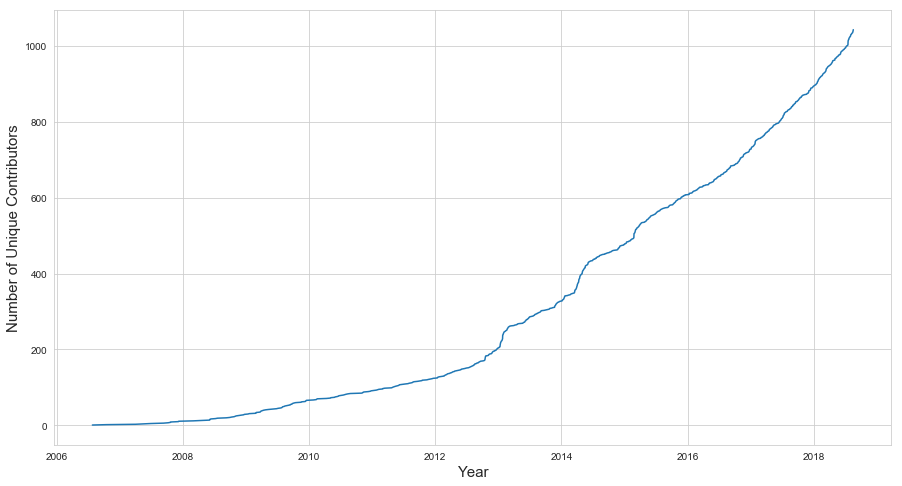

In [17]:
sns.set_style('whitegrid')
ax = unique_users_over_time.cumsum().plot(figsize=(15,8),legend=None)
ax.set_ylabel('Number of Unique Contributors', fontsize=15);
ax.set_xlabel('Year', fontsize=15);

# 7 Contributor Co-Editing Network

In [19]:
import networkx as nx

In [ ]:
G = nx.DiGraph()
for line in open('../data/'+PLACE+'-users.edgelist','r'):
    sourceLabel, targetLabel, weight = line.split(",")
    weight = int(weight)
    if weight > 100:
        G.add_edge(sourceLabel, targetLabel, weight=weight)

In [ ]:
len(G.nodes())

In [ ]:
nx.draw_spring(G, figsize=(15,8), with_labels=True)

In [ ]:
nx.write_graphml(G,'/data/www/'+PLACE+'.graphml');
print("Download the file at: http://yetilabs.science/"+PLACE+".graphml")

# 8 Versions

In [ ]:
ax = buildings.version.hist(figsize=(10,5),bins=np.arange(1,buildings.version.max(),1))
ax.set_yscale('log')

### Most edited buildings?

In [ ]:
buildings.sort_values(by='version', ascending=False).head()

# Minor Versions?

In [ ]:
df.minorVersion.value_counts()

In [ ]:
ax = buildings[buildings.minorVersion>0].groupby('date').aggregate({'id':'count'}).plot(figsize=(15,8));
ax.set_title("When Minor Versions Happen (Geometry Only Changes)")

# 10 Evolution of the Map: Roads --> Buildings?

In [ ]:
ax = df[(df.version==1) & (df.minorVersion==0)].groupby('date').aggregate({'building':'count','highway':'count','amenity':'count'}).cumsum().plot(figsize=(15,8))
ax.set_title('Creation of Objects overtime');
ax.set_yscale('LOG')

# Learning about Names

In [ ]:
def extract_key(attributeString,attr):
    if type(attributeString)==str:
        try:
            tags   = attributeString.split("|-|")
            tuples = [x.split("-->") for x in tags]
            keys   = [x[0] for x in tuples]
            values = [x[1] for x in tuples]
            if attr in keys:
                return values[keys.index(attr)]
            else:
                return np.NaN
        except:
            print(attributeString)
            print("keys", keys)
            raise
    return np.NaN

In [ ]:
df['nameAdded'] = df.aA.apply(lambda x: extract_key(x,'name'))

## When were names added to roads?

In [ ]:
ax = df[pd.isnull(df.highway)].groupby('date').aggregate({'nameAdded':'count'}).plot(figsize=(15,8))
ax.set_title('When the `name` attribute was added to objects on the map',fontsize=18);

# Top 15 Mappers in Last month

In [ ]:
df[df.date > datetime.date(2018,9,1)].groupby('user').aggregate({'id':'count'}).sort_values(by='id',ascending=False).head(15)


## A heatmap?

In [ ]:
import json
featColl = {'type':'FeatureCollection','features':[]}
for date, edits in df[pd.notnull(df.building)].groupby('date'):
    try:
        geometryColl = edits.center.apply(lambda x: {'type':'Point','coordinates':[float(y) for y in x.split(",")]})
        geojson = {
            'geometry':{'type':'GeometryCollection','geometries':list(geometryColl)},
            'type':"Feature",
            'properties': {'days_since_2005': (date - datetime.date(2005,1,1) ).days, 'edits':len(edits)}
        }
        featColl['features'].append(geojson)
    except:
        print("err--moving on")
    
json.dump(featColl, open("/data/www/map/data/"+PLACE+".geojson",'w'))
print("\n\nCheck it out at: http://yetilabs.science/map?data=data/"+PLACE+".geojson")